1.  **Install and Import Necessary Libraries**

In [7]:
%%capture
pip install pysal

In [8]:
%%capture
pip install geopandas

In [9]:
%%capture
pip install libpysal

In [10]:
%%capture
pip install giddy

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysal
import geopandas as gpd
import libpysal
import pysal.explore as explore
import seaborn as sns
from libpysal.weights import Queen, Rook, KNN
from libpysal.weights import lat2W
import giddy
import esda
import mapclassify as mc

2.  **Load Data**

In [12]:
cali = gpd.read_file(r"/content/drive/MyDrive/Spatiotemp/stars data/california.dbf")

In [13]:
cali = cali.set_index('COUNTY')

In [14]:
cali_pd = pd.DataFrame(cali)

In [15]:
ca_join_csts = pd.read_csv(r"/content/drive/MyDrive/Spatiotemp/stars data/caJoinCSTS.csv")

In [16]:
%%capture
list(ca_join_csts)

In [17]:
ca_join_csts['NAME'] = ca_join_csts['COUNTY']

In [18]:
ca_join_csts_tab = pd.DataFrame(ca_join_csts.groupby('NAME')['TestVar0', 'TestVar1', 'TestVar2', 'TestVar3', 'TestVar4', 'TestVar5',
 'TestVar6', 'TestVar7', 'TestVar8', 'TestVar9', 'TestVar10', 'TestVar11', 'TestVar12', 'TestVar13', 'TestVar14', 'TestVar15',
 'TestVar16', 'TestVar17', 'TestVar18', 'TestVar19', 'TestVar20', 'TestVar21', 'TestVar22', 'TestVar23', 'TestVar24', 'TestVar25',
 'TestVar26', 'TestVar27', 'TestVar28', 'TestVar29', 'TestVar30', 'TestVar31', 'TestVar32'].sum())
#hub_invest_table = pd.DataFrame(hub_invest_new.groupby('FUNDING AGENCY NAME')['HUBZones_w_invest'].sum())

In [19]:
ca_join_csts_tab.head()

,TestVar0,TestVar1,TestVar2,TestVar3,TestVar4,TestVar5,TestVar6,TestVar7,TestVar8,TestVar9,TestVar10,TestVar11,TestVar12,TestVar13,TestVar14,TestVar15,TestVar16,TestVar17,TestVar18,TestVar19,TestVar20,TestVar21,TestVar22,TestVar23,TestVar24,TestVar25,TestVar26,TestVar27,TestVar28,TestVar29,TestVar30,TestVar31,TestVar32
NAME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alameda,85.2069,89.9416,92.7569,96.2745,102.9214,80.0180,88.1655,83.7374,92.4945,111.3963,87.4952,104.3796,107.7753,116.4431,100.0036,96.1219,114.1550,86.3843,93.0094,106.0591,88.9684,109.3655,99.6308,109.6786,93.7715,103.8669,85.6951,105.5247,98.5094,88.0611,109.7936,101.3722,84.4227
Alpine,98.7312,118.9350,106.0394,95.1206,91.5354,101.7275,113.2794,88.2126,90.1161,89.6725,92.5644,85.3093,99.3269,105.3229,93.3690,89.7597,88.4905,106.6829,108.0783,98.9236,105.8863,99.9817,98.1639,107.3220,98.8766,102.1640,114.9599,78.5757,93.3266,96.9335,111.5323,92.2317,115.5124
Amador,105.3571,108.9284,71.2804,105.0018,98.9196,100.1208,84.3229,96.2510,91.4782,110.1511,115.7059,110.3203,102.2780,108.5262,101.5472,111.4774,86.1800,101.5755,107.9162,92.4511,108.1323,89.4499,92.3760,84.9243,95.4483,100.2826,88.4808,92.6639,104.9683,104.6458,81.1663,111.2881,110.0394
Butte,94.7674,105.5802,93.4156,99.0694,87.7443,95.4140,95.1671,84.0334,111.0916,109.4729,104.5499,97.5990,117.3454,104.3490,86.6560,89.6997,94.7395,94.4187,85.4302,107.1767,95.6461,102.1459,103.7640,104.9654,94.0856,114.4212,98.2450,98.4188,85.4937,102.2637,99.6298,101.5356,103.0868
Calaveras,112.3704,93.2881,92.8154,96.5728,106.1474,101.8777,83.0833,103.5663,72.9813,91.7154,105.0939,94.9772,108.2273,107.6917,93.2482,88.3924,105.0676,100.8249,106.0694,112.1025,108.0396,91.7236,98.7440,91.5893,109.7129,102.2380,103.1691,92.7793,90.5600,87.3232,101.0778,94.1294,92.2332


In [20]:
ca_join_csts_new = cali.merge(ca_join_csts_tab, on='NAME', how='inner')
#hub_invest = pd.merge(hub_df,invest,on='GEOID10',how='outer')

In [21]:
cali_CSTS_new = pd.DataFrame(ca_join_csts_new.groupby('NAME')['AREA', 'PERIMETER', 'CO06_D00_', 'CO06_D00_I','NAME', 'LSAD',
 'LSAD_TRANS','TestVar0', 'TestVar1', 'TestVar2', 'TestVar3', 'TestVar4', 'TestVar5',
 'TestVar6', 'TestVar7', 'TestVar8', 'TestVar9', 'TestVar10', 'TestVar11', 'TestVar12', 'TestVar13', 'TestVar14', 'TestVar15',
 'TestVar16', 'TestVar17', 'TestVar18', 'TestVar19', 'TestVar20', 'TestVar21', 'TestVar22', 'TestVar23', 'TestVar24', 'TestVar25',
 'TestVar26', 'TestVar27', 'TestVar28', 'TestVar29', 'TestVar30', 'TestVar31', 'TestVar32'].sum())

In [22]:
time_series = {}

**Setting up the weights**

In [23]:
cali_final = cali.merge(cali_CSTS_new, on='NAME')

In [24]:
#create dictionary to assign years to columns
time_series = {'AREA_x':'AREA_x', 'PERIMETER_x':'PERIMETER_x', 'CO06_D00__x':'CO06_D00__x', 'CO06_D00_I_x':'CO06_D00_I_x',
 'STATE':'STATE', 'NAME':'NAME', 'LSAD':'LSAD', 'LSAD_TRANS':'LSAD_TRANS', 'geometry':'geometry', 'AREA_y':'AREA_y',
 'PERIMETER_y':'PERIMETER_y', 'CO06_D00__y':'CO06_D00__y', 'CO06_D00_I_y':'CO06_D00_I_y', 'TestVar0':1969, 'TestVar1':1970,
 'TestVar2':1971, 'TestVar3':1972, 'TestVar4':1973, 'TestVar5':1974, 'TestVar6':1975, 'TestVar7':1976, 'TestVar8':1977,
 'TestVar9':1978, 'TestVar10':1979, 'TestVar11':1980, 'TestVar12':1981, 'TestVar13':1982, 'TestVar14':1983, 'TestVar15':1984,
 'TestVar16':1985, 'TestVar17':1986, 'TestVar18':1987, 'TestVar19':1988, 'TestVar20':1989, 'TestVar21':1990, 'TestVar22':1991,
 'TestVar23':1992, 'TestVar24':1993, 'TestVar25':1994, 'TestVar26':1995, 'TestVar27':1996, 'TestVar28':1997, 'TestVar29':1998,
 'TestVar30':1999, 'TestVar31':2000, 'TestVar32':2001}

In [25]:
cali_final = cali_final.rename(columns=time_series) #rename columns for years

In [162]:
w = libpysal.io.open('/content/drive/MyDrive/Spatiotemp/stars data/states48.gal')

In [27]:
#create contiguity and nearest neighbor weights
w_rook = Rook.from_dataframe(cali_final)
w_queen = Queen.from_dataframe(cali_final)
w_KNN = KNN.from_dataframe(cali_final, k=3)

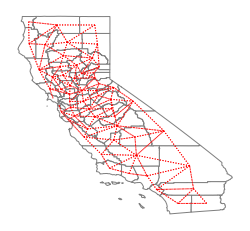

In [28]:
#plot queen lattice to check work
ax = cali_final.plot(edgecolor='grey', facecolor='w')
f,ax = w_queen.plot(cali_final, ax=ax, 
        edge_kws= dict(color='r', linestyle=':', linewidth=1),
        node_kws = dict(marker=''))
ax.set_axis_off()

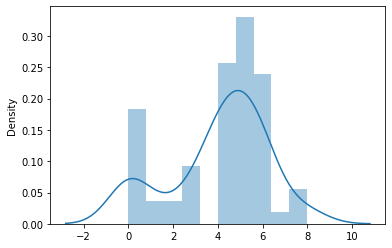

In [29]:
queen_card = pd.Series(w_queen.cardinalities)
sns.distplot(queen_card, bins=10)

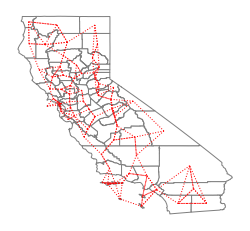

In [30]:
#plot k nearest neighbor lattice
ax = cali_final.plot(edgecolor='grey', facecolor='w')
f,ax = w_KNN.plot(cali_final, ax=ax, 
        edge_kws= dict(color='r', linestyle=':', linewidth=1),
        node_kws = dict(marker=''))
ax.set_axis_off()

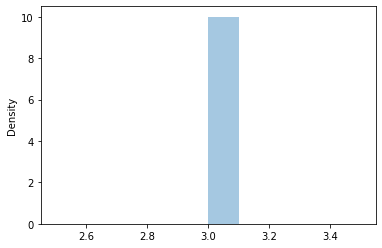

In [31]:
knn_card = pd.Series(w_KNN.cardinalities)
sns.distplot(knn_card, bins=10)
#k=3, so every observation has 3 neighbors

In [32]:
%%capture
w_queen.neighbors

In [33]:
w_queen.s0

276.0

**Exploratory Spatial Data Analysis**

In [36]:
cali_final.head()

,AREA_x,PERIMETER_x,CO06_D00__x,CO06_D00_I_x,STATE,NAME,LSAD,LSAD_TRANS,geometry,AREA_y,PERIMETER_y,CO06_D00__y,CO06_D00_I_y,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001
0,1.775331,7.154696,2,1,06,Siskiyou,06,County,"POLYGON ((-123.23076 42.00384, -123.19236 42.0...",1.775331,7.154696,2,1,95.3059,99.8411,117.9680,92.0215,113.9721,94.0481,102.3706,115.8994,90.1483,101.7815,109.2724,96.8898,107.8411,93.5182,92.8265,106.5336,102.9590,88.6728,104.6709,103.9020,82.0166,73.3606,81.7427,91.1879,91.3503,90.0636,93.9875,92.6877,112.3907,96.8754,106.8169,123.6963,91.8727
1,0.284410,2.851002,3,2,06,Del Norte,06,County,"POLYGON ((-124.21161 41.99846, -124.12619 41.9...",0.284410,2.851002,3,2,87.5385,91.1604,112.5482,105.5469,107.1714,120.5337,91.8952,97.6353,95.3262,88.0445,87.8427,101.2395,94.5902,85.8045,81.3776,74.7484,101.9384,113.1101,91.2077,95.4387,108.1652,99.3882,101.0377,90.6965,88.2473,100.9580,110.2134,116.2484,113.3438,92.4299,110.2685,110.7956,120.0002
2,1.175683,4.538583,4,3,06,Modoc,06,County,"POLYGON ((-121.44760 41.99717, -121.43961 41.9...",1.175683,4.538583,4,3,116.8178,87.8079,95.4210,96.3661,103.5583,92.6942,101.5756,113.6669,107.3134,88.7867,80.8881,106.1587,103.2024,89.5482,104.8642,94.7074,106.8956,92.5529,110.4259,81.2918,92.7084,104.1454,92.4380,95.4881,95.3456,99.9992,85.5180,94.1679,95.5796,106.2079,90.3006,114.9913,96.9040
3,0.996595,4.881946,5,4,06,Humboldt,06,County,"POLYGON ((-124.05515 41.46478, -124.04183 41.4...",0.996595,4.881946,5,4,109.1613,85.1736,101.9561,104.9612,97.8213,110.5714,101.0551,112.3158,98.5662,101.1730,99.5871,86.8344,116.4012,89.3715,101.4741,96.2684,90.8776,108.8141,103.6559,104.0575,116.3767,94.5016,102.7415,104.5207,97.3588,100.4127,106.8059,104.8036,103.2303,102.8248,86.0503,113.4278,114.3870
4,0.884485,6.044118,6,5,06,Trinity,06,County,"POLYGON ((-122.58600 41.35383, -122.58580 41.3...",0.884485,6.044118,6,5,82.5217,99.4662,127.8934,101.1926,105.3770,86.3075,110.1701,102.1039,110.4554,114.3641,90.9523,97.3942,94.5748,103.4688,96.0285,110.6658,99.2180,111.2736,113.0385,96.9160,88.7891,94.1884,112.7242,100.6896,96.2921,105.7377,88.9236,117.1025,101.6119,89.4892,99.6777,106.6525,109.8785


In [37]:
#list time series clusters
cluster_variables = [1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001]

IndexError: ignored

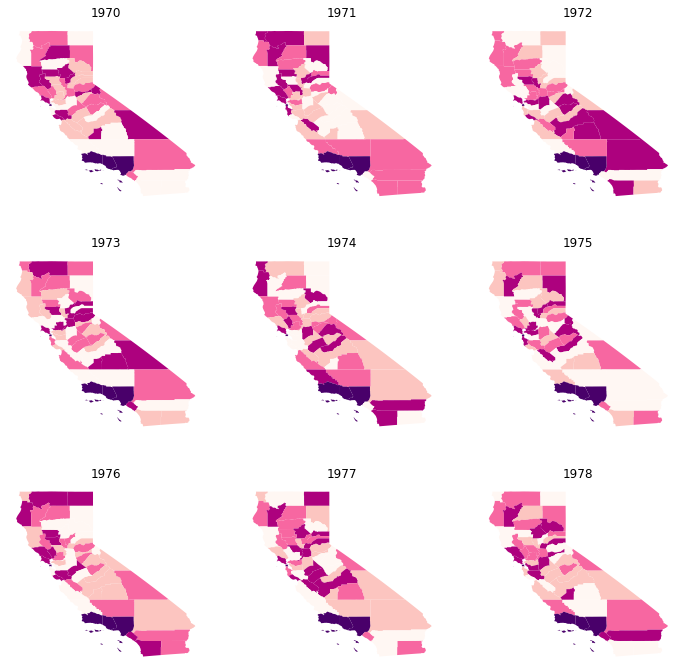

In [38]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    for j in range(i):
      ax = axs[j]
    # Plot the map
    cali_final.plot(
        column=col, 
        ax=ax,
        scheme='Quantiles', 
        linewidth=0,
        cmap='RdPu'
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()
##SOURCE: https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html

In [ ]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [esda.moran.Moran(cali_final[datum], w_queen) for datum in cluster_variables]
# Structure results as a list of tuples
mi_results = [
    (datum, res.I, res.p_sim) for datum,res in zip(cluster_variables, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results,
    columns=['Datum', "Moran's I", 'P-value']
).set_index('Datum')
table
##SOURCE: https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html

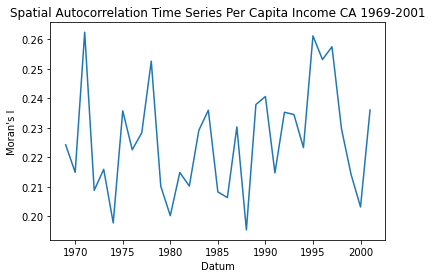

In [52]:
sns.lineplot(x='Datum', y="Moran's I", data=table)
plt.title('Spatial Autocorrelation Time Series Per Capita Income CA 1969-2001')
plt.show()

**Spatial Markov Chains**

In [41]:
c = np.array([['b','a','c'],['c','c','a'],['c','b','c'],['a','a','b'],['a','b','c']])

In [43]:
m = giddy.markov.Markov(c, summary=False)

In [45]:
print(m.transitions)

[[1. 2. 1.]
 [1. 0. 2.]
 [1. 1. 1.]]


In [47]:
m.p

array([[0.25      , 0.5       , 0.25      ],
       [0.33333333, 0.        , 0.66666667],
       [0.33333333, 0.33333333, 0.33333333]])

In [46]:
m.steady_state

array([0.30769231, 0.28846154, 0.40384615])

In [54]:
f = pd.DataFrame(cali_final)

In [56]:
f.shape

(68, 46)

In [130]:
pci = f[[1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000]].to_numpy()

In [131]:
pci.T

array([[ 95.3059,  87.5385, 116.8178, ..., 116.7929, 100.1733,  95.4262],
       [ 99.8411,  91.1604,  87.8079, ...,  97.7116,  90.7824,  87.0611],
       [117.968 , 112.5482,  95.421 , ...,  87.265 , 100.982 ,  98.9731],
       ...,
       [ 96.8754,  92.4299, 106.2079, ...,  93.5214,  89.5107,  97.3439],
       [106.8169, 110.2685,  90.3006, ...,  93.3802, 100.1112,  95.0933],
       [123.6963, 110.7956, 114.9913, ..., 103.2311, 111.7545, 103.5274]])

In [ ]:
%%capture
years = range(1969, 2001)
names = np.array(f.groupby(by="NAME"))
order1969 = np.argsort(pci[0,:])
order2001 = np.argsort(pci[-1,:])
names1969 = names[order1969[::-1]]
names2001 = names[order2001[::-1]]
first_last = np.vstack((names1969,names2000))
from pylab import rcParams
rcParams['figure.figsize'] = 15,10
plt.plot(years,pci.T)
for i in range(32):
    plt.text(1968.5, 450-(i*.5), first_last[0][i],fontsize=10).all
    plt.text(2001.5, 450-(i*.5), first_last[1][i],fontsize=10).all
plt.xlim((years[0], years[-1]))
plt.ylim((0, 200))
plt.ylabel('Name',fontsize=10)
plt.xlabel('Years',fontsize=10)
plt.title('Absolute Dynamics',fontsize=18)

In [ ]:
%%capture
years = range(1969,2001)
rpci= (pci.T / pci.mean(axis=1)).T
names = np.array(f.groupby(by="NAME"))
order1969 = np.argsort(rpci[0,:])
order2000 = np.argsort(rpci[-1,:])
names1969 = names[order1969[::-1]]
names2000 = names[order2000[::-1]]
first_last = np.vstack((names1969,names2000))
from pylab import rcParams
rcParams['figure.figsize'] = 15,10
plt.plot(years,rpci.T)
for i in range(32):
    plt.text(1915,1.91-(i*0.041), first_last[0][i],fontsize=10)
    plt.text(2010.5,1.91-(i*0.041), first_last[1][i],fontsize=10)
plt.xlim((years[0], years[-1]))
plt.ylim((0, 1.94))
plt.ylabel(r"$y_{i,t}/\bar{y}_t$",fontsize=10)
plt.xlabel('Years',fontsize=10)
plt.title('Relative Dynamics',fontsize=10)

In [158]:
q5 = np.array([mc.Quantiles(y,k=5).yb for y in pci]).transpose()
print(q5[:, 0])

[2 2 4 1 4 2 3 4 0 2 4 2 4 1 1 3 3 0 3 3 0 0 0 0 1 0 1 1 4 2 3 4]


In [159]:
m5 = giddy.markov.Markov(q5)

The Markov Chain is irreducible and is composed by:
1 Recurrent class (indices):
[0 1 2 3 4]
0 Transient classes.
The Markov Chain has 0 absorbing states.


In [160]:
m5.transitions

array([[160.,  80.,  78.,  72.,  79.],
       [ 76., 122.,  72.,  59.,  73.],
       [ 68.,  70., 111.,  70.,  83.],
       [ 69.,  55.,  76., 126.,  76.],
       [ 96.,  75.,  65.,  75., 158.]])

In [161]:
giddy.ergodic.fmpt(m5.p)

array([[4.57142857, 6.15175039, 5.98659501, 6.35555789, 5.48946285],
       [5.39074144, 5.33333333, 5.90249024, 6.40217628, 5.40378149],
       [5.51011596, 6.13642542, 5.33333333, 6.20668753, 5.2514529 ],
       [5.50388006, 6.40054501, 5.83279462, 5.33333333, 5.35178021],
       [5.28699083, 6.23304362, 6.18604336, 6.31103366, 4.57142857]])

In [166]:
sm = giddy.markov.Spatial_Markov(rpci, w_queen, fixed = True, k = 5,m=5)

In [167]:
sm.p

array([[0.21395349, 0.19767442, 0.19069767, 0.19069767, 0.20697674],
       [0.20093458, 0.17990654, 0.17990654, 0.21028037, 0.22897196],
       [0.17266187, 0.19904077, 0.21822542, 0.21103118, 0.19904077],
       [0.20772947, 0.20289855, 0.22705314, 0.16425121, 0.19806763],
       [0.19570406, 0.2124105 , 0.19570406, 0.23150358, 0.1646778 ]])

In [168]:
sm.summary

<bound method Spatial_Markov.summary of <giddy.markov.Spatial_Markov object at 0x7fe8124ee310>>

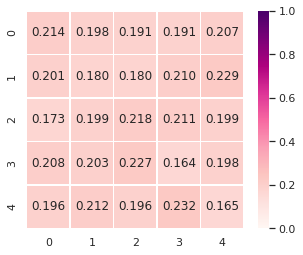

In [171]:
sns.set()

fig, ax = plt.subplots(figsize = (5,4))
im = sns.heatmap(sm.p, annot=True, linewidths=.5, ax=ax, cbar=True, vmin=0, vmax=1,
                          square=True,  cmap="RdPu",fmt='.3f')

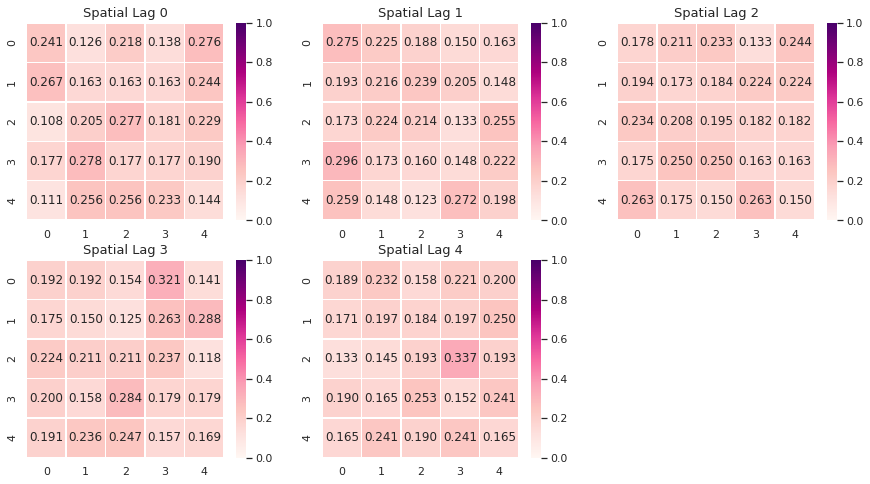

In [172]:
fig, axes = plt.subplots(2,3,figsize = (15,8)) 

for i in range(2):
    for j in range(3):
        ax = axes[i,j]
        if i==1 and j==2:
            ax.axis('off')
            continue
        p_temp = sm.P[i*3+j]
        im = sns.heatmap(p_temp, annot=True, linewidths=.5, ax=ax, cbar=True, vmin=0, vmax=1,
                          square=True, cmap="RdPu",fmt='.3f')
        ax.set_title("Spatial Lag %d"%(i*3+j),fontsize=13)